# Read and plot DTS data
This notebook shows how to read DTS data from a .csv file and plot it.

In [19]:
# load packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
import random
import scipy
from scipy.integrate import odeint
from scipy.integrate import ode, complex_ode
from scipy.optimize import minimize
from findiff import FinDiff
import matplotlib.pyplot as plt
from time import perf_counter
from skimage import feature
from tqdm import tqdm
from skimage.filters import meijering, sato, frangi, hessian
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from symfit import parameters, variables, sin, cos, Fit
import pickle
import math
from scipy.interpolate import UnivariateSpline
from PyAstronomy import pyaC
import get_temp_amplitude
import lmfit
from tg_solver import tg_solve, tg
import pysindy as ps
from pysindy.feature_library import PolynomialLibrary
from pysindy.optimizers import STLSQ
from pysindy.feature_library import CustomLibrary

# import cv2

# matplotlib.use('TkAgg')
# %matplotlib qt
%matplotlib widget

# Set up data

In [5]:
# Read temperature data
infile = '../data/DTS/temp_cal_valid_cable_rmnoise.csv'
df_temp = pd.read_csv(infile, index_col=0)
df_temp.columns = pd.to_datetime(df_temp.columns)
df_temp.head()

,2023-08-09 17:09:32.415,2023-08-09 17:14:32.521,2023-08-09 17:19:32.622,2023-08-09 17:24:32.751,2023-08-09 17:29:32.871,2023-08-09 17:34:33.023,2023-08-09 17:39:33.151,2023-08-09 17:44:33.281,2023-08-09 17:49:33.393,2023-08-09 17:54:33.510,...,2023-08-29 13:21:53.278,2023-08-29 13:26:53.872,2023-08-29 13:31:54.456,2023-08-29 13:36:55.019,2023-08-29 13:41:55.583,2023-08-29 13:46:56.141,2023-08-29 13:51:56.718,2023-08-29 13:56:57.291,2023-08-29 14:01:57.900,2023-08-29 14:02:08.202
-22.999,21.8724,21.9242,21.7593,22.0574,22.2256,22.5217,22.7067,22.8808,23.2244,23.5173,...,25.5453,25.3991,25.4547,25.4546,25.6803,25.7883,25.9772,25.8514,25.8928,26.1549
-22.745,21.8849,21.9424,21.7415,22.0645,22.2294,22.5077,22.7098,22.8978,23.2494,23.5068,...,25.5339,25.4029,25.4845,25.4733,25.6727,25.8092,25.9818,25.8577,25.9044,26.1569
-22.490,21.8829,21.9581,21.7719,22.0786,22.2661,22.4844,22.7420,22.8877,23.2459,23.5008,...,25.5144,25.4283,25.4984,25.5012,25.6936,25.8112,25.9707,25.8581,25.9104,26.0933
-22.236,21.9095,21.9571,21.7812,22.0970,22.2612,22.4886,22.7592,22.8818,23.2265,23.4932,...,25.5312,25.4563,25.5038,25.5070,25.7078,25.7885,25.9619,25.8641,25.9341,26.1819
-21.982,21.9441,21.9227,21.7831,22.0871,22.2620,22.5016,22.7392,22.8826,23.2373,23.5235,...,25.5722,25.4460,25.5155,25.5173,25.7258,25.8020,25.9593,25.8840,25.9210,26.2319


In [6]:
# Put temperature data, optical distances and sampling times into numpy arrays
temp_arr = df_temp.to_numpy().T # we want to have the time to be in the 0-axis to be consistent with DAS data
times = pd.to_datetime(df_temp.columns)
dists = df_temp.index.to_numpy()

In [7]:
# plot selected DTS data over time
# enter water at: 560m, exit water at 7565m
start_dist = 2820 # east ridge at 2820m optical distance
end_dist = 3150 # seafloor from ~3150m optical distance onward

start_time = times[0] #datetime.datetime(2023,8,9)
end_time = times[-1] #datetime.datetime(2023,8,30)

t_idx_start = np.argmin(np.abs(times-start_time))
t_idx_end = np.argmin(np.abs(times-end_time))
d_idx_start = np.argmin(np.abs(dists-start_dist))
d_idx_end = np.argmin(np.abs(dists-end_dist))

plot_arr = temp_arr[t_idx_start:t_idx_end, d_idx_start:d_idx_end]
plot_times = times[t_idx_start:t_idx_end]
plot_dists = dists[d_idx_start:d_idx_end]


In [8]:
# filter = scipy.signal.butter(1, 0.0111, 'hp', fs=5, output='sos', analog=False) # 5 represents 5 second sampling rate
# Band pass filter 
filtered_arr = scipy.ndimage.gaussian_filter(plot_arr, 10, axes=1)

startt = datetime.datetime(2023, 8, 25, 0)
endt = datetime.datetime(2023, 8, 26, 16)
startind_t = np.absolute(plot_times - startt).argmin()
endind_t = np.absolute(plot_times - endt).argmin()

# startind_d = np.absolute(plot_dists - 2940).argmin()
# endind_d = np.absolute(plot_dists - 3000).argmin()

startind_d = np.absolute(plot_dists - 2900).argmin()
endind_d = np.absolute(plot_dists - 3300).argmin()

filtered_arr = scipy.ndimage.gaussian_filter(filtered_arr[startind_t:endind_t, startind_d:endind_d], 1.2)
plot_times_zoomed = plot_times[startind_t:endind_t]
plot_times_zoomed_int = plot_times_zoomed.astype('int64')
plot_dists_zoomed = plot_dists[startind_d:endind_d]

# Detecting the amplitude of the waves

## Making my own contours

In [9]:
contour_values = np.linspace(0.55, 2.2, 100) # 0.55
contour_values_legend = []
for i in range(len(contour_values)): contour_values_legend.append(str(contour_values[i]) + "ºC")

contour_points = {}
contour_points_arr = np.empty((len(contour_values), len(plot_times_zoomed)))
contour_points_og = np.empty((len(contour_values), len(plot_times_zoomed)))
# np.empty((len(contour_values), len(filtered_arr[:, 1])))
cvi = 0

for cv in contour_values:
    avg_zero_crossings = 0
    nan_inds = []
    real_inds = []
    contour_points[cv] = {}
    contour_points[cv]['x'] = []
    contour_points[cv]['t'] = []
    for i in range(len(filtered_arr[:, 0])):
        xc = pyaC.zerocross1d(plot_dists_zoomed, filtered_arr[i, :] - cv)
        if(len(xc) == 1):
            real_inds.append(i)
            contour_points_arr[cvi, i] = xc.flatten().tolist()[0]
            contour_points[cv]['x'].extend(xc.flatten().tolist())
            contour_points[cv]['t'].extend(np.full(len(xc), plot_times_zoomed_int[i]).tolist())
        else:
            nan_inds.append(i)
            contour_points_arr[cvi, i] = float('NaN')
        avg_zero_crossings = avg_zero_crossings + len(xc)
    # print('Temp contour =', cv, 'avg of', avg_zero_crossings/len(filtered_arr[:, 0]), 'zero crossings')
    
    nan_inds = np.array(nan_inds)
    real_inds = np.array(real_inds)

    contour_points_og[cvi] = contour_points_arr[cvi]
    # print(np.all(np.diff(plot_times_zoomed_int[real_inds]) > 0))

    contour_points_arr[cvi][nan_inds] = np.interp(plot_times_zoomed_int[nan_inds], np.array(contour_points[cv]['t']), contour_points[cv]['x'])
    # f = scipy.interpolate.interp1d(plot_times_zoomed_int[real_inds], contour_points_arr[cvi][real_inds], kind= "slinear")
    # try: contour_points_arr[cvi][nan_inds] = f(plot_times[nan_inds])
    # except: print(nan_inds)
    # contour_points_arr[cvi] = np.interp(plot_times_zoomed.astype('int64'), np.array(contour_points[cv]['t']).astype('int64'), contour_points[cv]['x'])
    cvi = cvi + 1


# np.interp(xc, plot_dists_zoomed, filtered_arr[i, :])

## Plotting

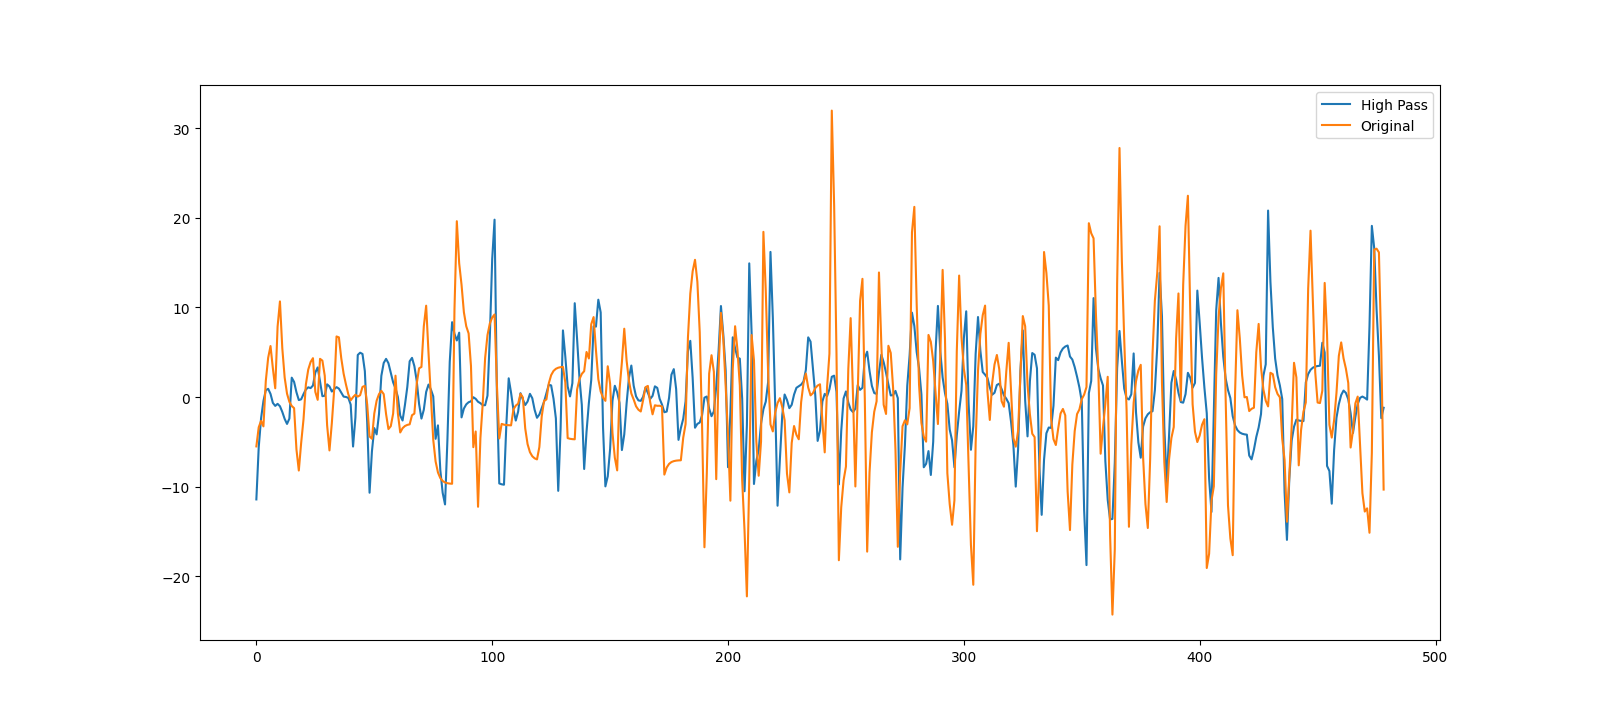

In [10]:
depths = np.empty(np.shape(contour_points_arr))
displacements = np.empty(np.shape(contour_points_arr))

filter = scipy.signal.butter(1, 0.5, 'hp', fs=5, output='sos', analog=False) # 5 represents 5 second sampling rate

for i in range(len(contour_points_arr[:, 0])):
    contours_high_pass = scipy.signal.sosfilt(filter, contour_points_arr[i, :] - np.median(contour_points_arr[i, :]))
    depths[i] = np.median(contour_points_arr[i, :])
    displacements[i] = contours_high_pass

i = 80 # np.absolute(depths - 3027).argmin()
# print(i)
contours_high_pass = scipy.signal.sosfilt(filter, contour_points_arr[i, :] - np.median(contour_points_arr[i, :]))

fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
ax.plot(displacements[i, :])
ax.plot(displacements[i - 70, :])
# ax.plot(contour_points_arr[i, :] - np.median(contour_points_arr[i, :]))
ax.legend(['High Pass', 'Original'])

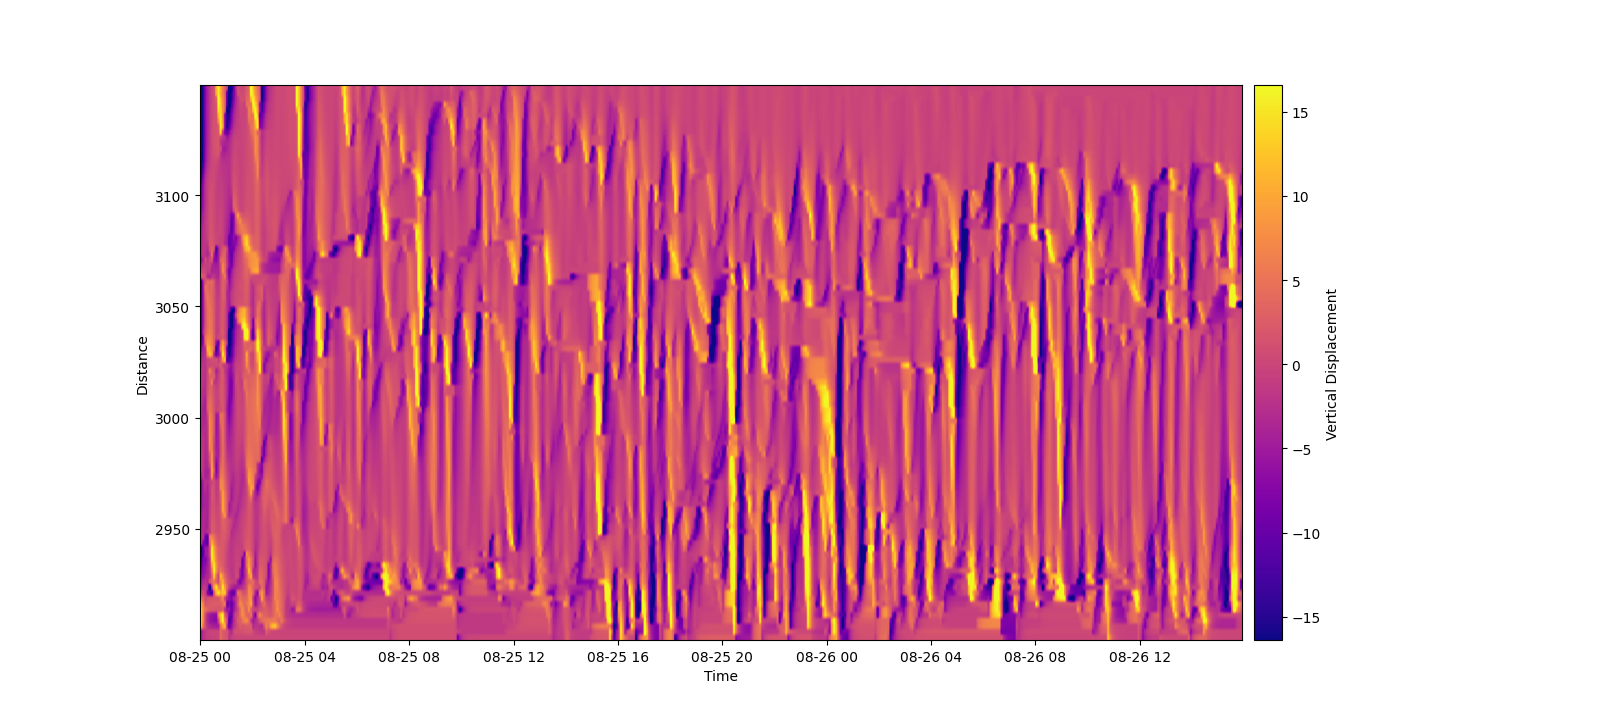

In [11]:

fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
# for i in range(len(displacements[:, 0])): plt.plot(plot_times_zoomed, depths[i, :] + displacements[i, :])
im1 = ax.imshow(displacements, origin='lower',
           aspect='auto',
            extent=[plot_times_zoomed[0], plot_times_zoomed[-1],
                   plot_dists_zoomed[0], plot_dists_zoomed[-1]],
            cmap='plasma',
            vmin=np.percentile(displacements[~np.isnan(displacements)],1),
            vmax=np.percentile(displacements[~np.isnan(displacements)],99),
            )
ax.set_ylabel('Distance')
ax.set_xlabel('Time')
# plt.legend(contour_values_legend)

cbar = fig.colorbar(im1, pad=0.01)
cbar.set_label('Vertical Displacement')
plt.show()
# plt.plot(datetime.datetime(*contour_points[contour_values[0]]['t']), contour_points[contour_values[0]]['x'], '.')
# plt.plot(plot_times_zoomed[real_inds], contour_points_arr[0][real_inds], '.')
# print(interpf(plot_times_zoomed_int[nan_inds]))


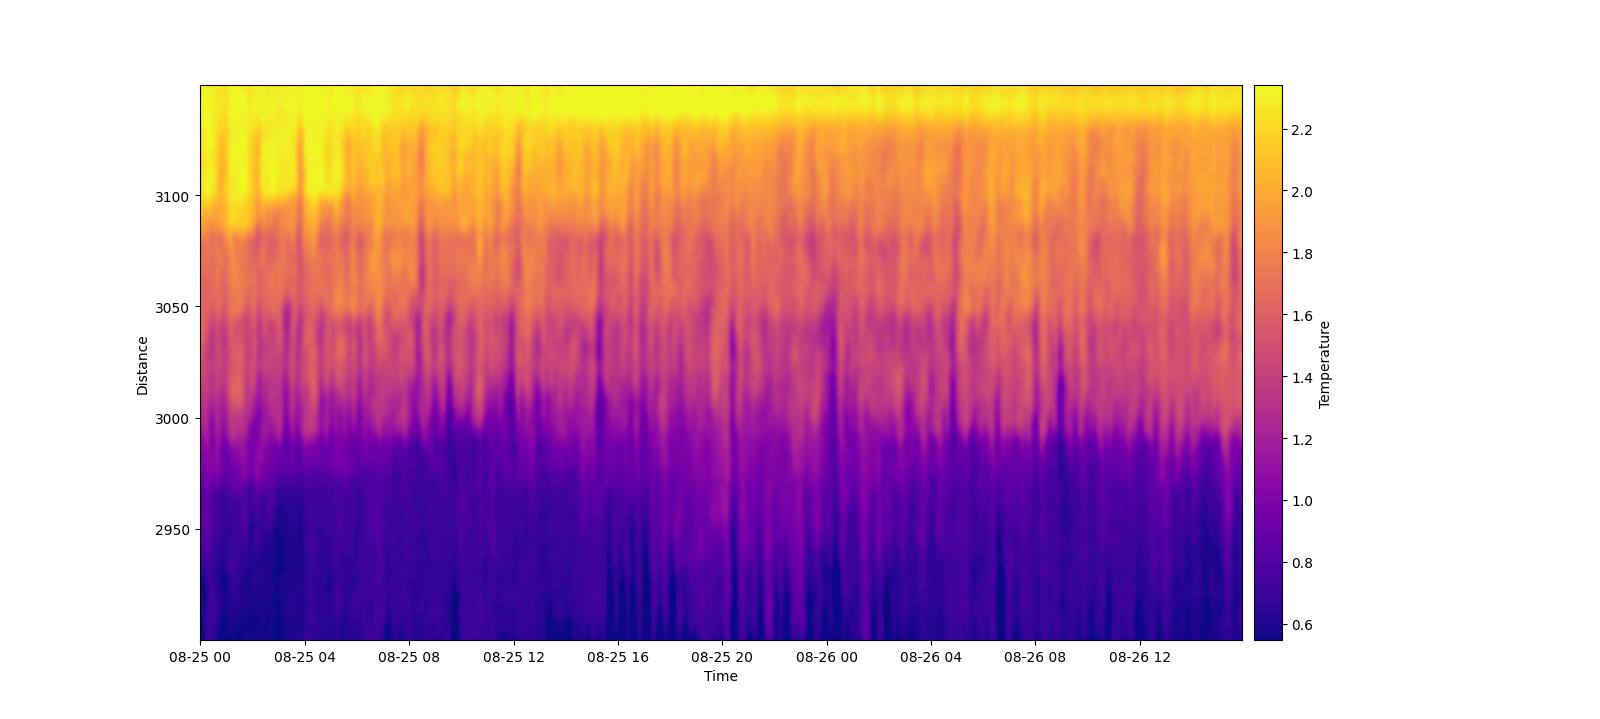

In [12]:
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
im1 = ax.imshow(filtered_arr.T, origin='lower',
           aspect='auto',
            extent=[plot_times_zoomed[0], plot_times_zoomed[-1],
                   plot_dists_zoomed[0], plot_dists_zoomed[-1]],
            cmap='plasma',
            vmin=np.percentile(filtered_arr[~np.isnan(filtered_arr)],1),
            vmax=np.percentile(filtered_arr[~np.isnan(filtered_arr)],99),
            )
# for i in range(len(contour_values)): plt.plot(plot_times_zoomed, contour_points_arr[i], '-')
# for i in range(len(contour_values)): plt.plot(contour_points[contour_values[i]]['t'], contour_points[contour_values[i]]['x'], '.')
# plt.contour(plot_times_zoomed, plot_dists_zoomed, filtered_arr.T, contour_values)

ax.set_ylabel('Distance')
ax.set_xlabel('Time')
# plt.legend(contour_values_legend)

cbar = fig.colorbar(im1, pad=0.01)
cbar.set_label('Temperature')
plt.show()

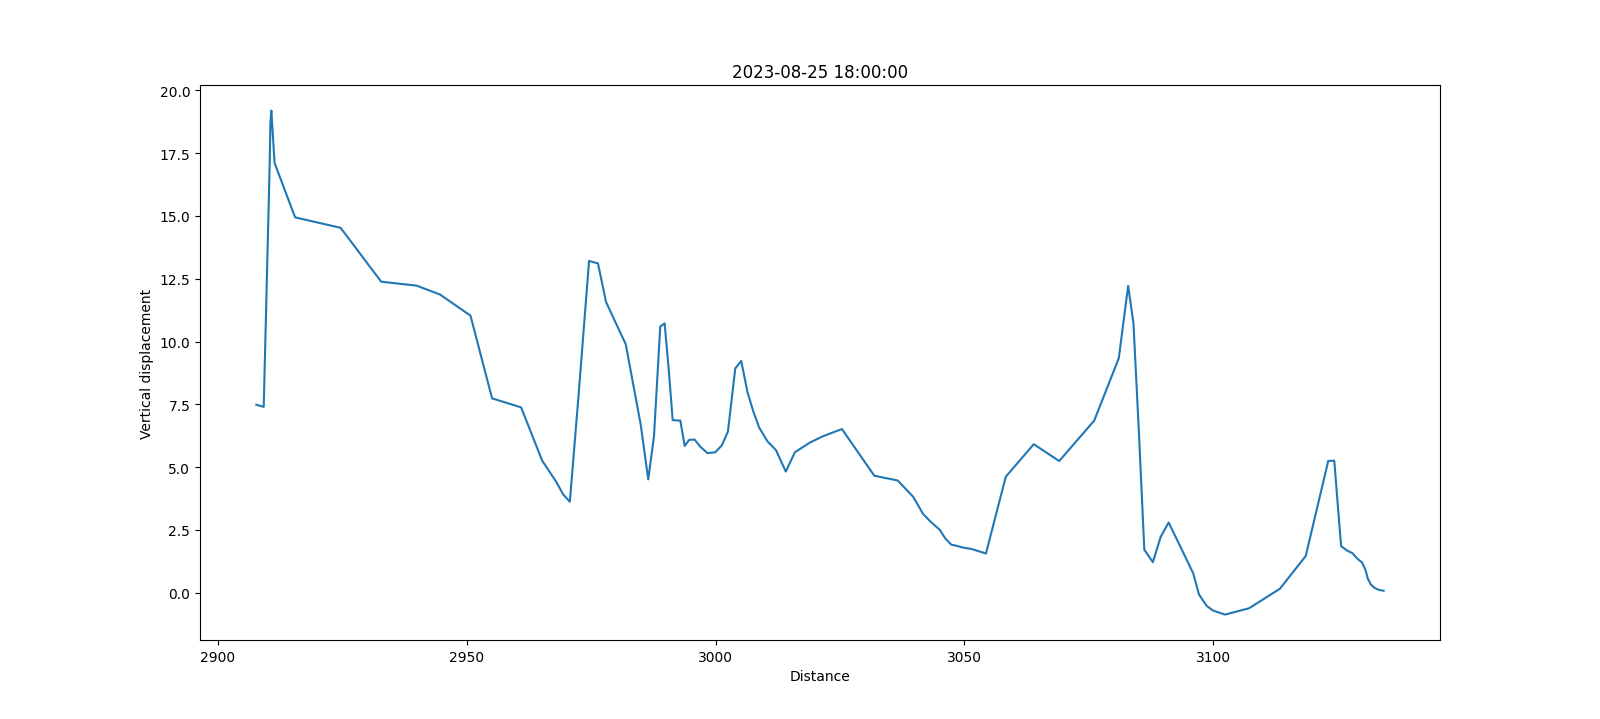

In [13]:
time_slice = datetime.datetime(2023, 8, 25, 18)
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
ax.plot(depths[:, np.absolute(plot_times_zoomed - time_slice).argmin()], displacements[:, np.absolute(plot_times_zoomed - time_slice).argmin()])
ax.set_xlabel('Distance')
ax.set_ylabel('Vertical displacement')
ax.set_title(str(time_slice))
plt.show()

## Set up SINDy

In [24]:
# Example data (replace with your actual data)
z = np.linspace(0, 10, 100)
phi = np.sin(z)  # Replace with your phi(z) data
dphi = np.gradient(phi, z)
d2phi = np.gradient(dphi, z)

# Example constants (replace with your actual values)
N = np.ones_like(z)  # Buoyancy frequency (replace with actual data if varying)
k = 1  # Wavenumber
c = 1  # Phase speed

# Define custom feature functions based on the Taylor-Goldstein equation
def term1(x):
    phi = x[:, 0]
    d2phi = x[:, 1]
    return d2phi + k**2 * phi

def term2(x):
    phi = x[:, 0]
    return N**2 / phi

# Custom feature library
custom_library = CustomLibrary(library_functions=[term1, term2], function_names=['term1', 'term2'])

# SINDy optimizer
optimizer = STLSQ(threshold=0.1)

# Construct SINDy model
model = ps.SINDy(optimizer=optimizer, feature_library=custom_library)

# Combine data into the format expected by SINDy
data = np.vstack([phi, d2phi]).T

# Verify shape of data
print("Shape of data:", data.shape)

# Fit the model
model.fit(data)
model.print()

# Extract the identified equations
identified_eqs = model.coefficients()

# Solve for U(z)
term1_coeff = identified_eqs[0]
term2_coeff = identified_eqs[1]
U = term2_coeff / term1_coeff + c

# Plot the identified background velocity U(z)
plt.plot(z, U)
plt.xlabel('Depth (z)')
plt.ylabel('Background Velocity U(z)')
plt.title('Identified Background Velocity U(z)')
plt.show()

print("Identified Background Velocity U(z):", U)


Shape of data: (100, 2)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed